# Enrichr Compressed Bar Chart Figure 

This appyter creates a publishable figure summarizing enrichment analysis results from Enrichr (https://amp.pharm.mssm.edu/Enrichr/). 

The resulting figure will contain the top 5 enriched terms and their corresponding p-values for each library chosen. Colored bars correspond to terms with significant p-values (<0.05). An asterisk (*) next to a p-value indicates the term also has a significant adjusted p-value (<0.05).

In [1]:
import pandas as pd 
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
from matplotlib.ticker import MaxNLocator
from IPython.display import display,FileLink, Markdown

### Input options

In [2]:
gene_list_filename = ''
gene_list_input = '''Nsun3
Polrmt
Nlrx1
Sfxn5'''
transcription_libraries = ['ARCHS4_TFs_Coexp']
pathways_libraries = ['ARCHS4_Kinases_Coexp']    
ontologies_libraries = ['GO_Biological_Process_2018'] 
diseases_drugs_libraries = ['Achilles_fitness_decrease']
cell_types_libraries = ['Allen_Brain_Atlas_down']    
miscellaneous_libraries = ['Chromosome_Location_hg19']    
legacy_libraries = ['BioCarta_2013'] 
crowd_libraries = ['Aging_Perturbations_from_GEO_down']
figure_file_format = ['png']
output_file_name = 'Enrichr_results'
color = "Red"
annot_dict_filename = ''
final_output_file_names = [str(output_file_name+'.'+file_type) for file_type in figure_file_format]

### Import gene list

In [3]:
# Import gene list as file or from text box file
# Will choose file upload over textbox if a file is given 
if gene_list_filename != '':
    open_gene_list_file = open(gene_list_filename,'r')
    lines = open_gene_list_file.readlines()
    genes = [x.strip() for x in lines]
    open_gene_list_file.close()
else:
    genes = gene_list_input.split('\n')
    genes = [x.strip() for x in genes]

### Import term conversion file (Optional)

In [4]:
# Conversion dictionary for long terms
annot_dict = {}

# Import term conversion file if one is specified 
if annot_dict_filename != '':
    conversion_file = pd.read_excel(annot_dict_filename, 'Sheet1', header=None)
    annot_dict = dict(zip([x.strip() for x in conversion_file[0]], [x.strip() for x in conversion_file[1]]))

### Map bar color choice 

In [5]:
# Color for barchart 
color_conversion={
    'Red':'tomato',
    'Blue':'lightskyblue',
    'Green':'mediumspringgreen',
    'Grey':'lightgrey',
    'Orange':'orange',
    'Purple':'plum',
    'Yellow':'yellow',
    'Pink':'lightpink'
}

color = color_conversion[color]

### Get Enrichr Results

In [6]:
# Combine libraries from all categories 
enrichr_libraries = np.sort(transcription_libraries+pathways_libraries+ontologies_libraries+diseases_drugs_libraries+cell_types_libraries+miscellaneous_libraries+legacy_libraries+crowd_libraries)

# Function to get Enrichr Results 
# Takes a gene list and Enrichr libraries as input 
def Enrichr_API(enrichr_gene_list, all_libraries):


    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []
    library_success = []
    short_id = ''

    for library_name in all_libraries : 
        ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList'
        genes_str = '\n'.join(enrichr_gene_list)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }

        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')

        data = json.loads(response.text)
        time.sleep(0.5)
        ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        short_id = data["shortId"]
        gene_set_library = library_name
        response = requests.get(
            ENRICHR_URL + query_string % (user_list_id, gene_set_library)
         )
        if not response.ok:
            raise Exception('Error fetching enrichment results')
        try:
            data = json.loads(response.text)
            results_df  = pd.DataFrame(data[library_name][0:5])
            all_terms.append(list(results_df[1]))
            all_pvalues.append(list(results_df[2]))
            all_adjusted_pvalues.append(list(results_df[6]))
            library_success.append(library_name)
        except:
            print('Error for ' + library_name + ' library')

    return([all_terms,all_pvalues,all_adjusted_pvalues,str(short_id),library_success])


In [7]:
#get enrichr results
results = Enrichr_API(genes,enrichr_libraries)

Error for BioCarta_2013 library


### Plot Enrichr Results 

In [8]:
# Function plots results 
# Takes all terms, all p-values, all adjusted p-values, plot title, Enrichr libraries , and specified figure format
def enrichr_figure(all_terms,all_pvalues, all_adjusted_pvalues, plot_names, all_libraries, fig_format, bar_color): 
    
    # rows and columns depend on number of Enrichr libraries submitted 
    rows = []
    cols = []
    
    # Bar colors
    if bar_color!= 'lightgrey':
        bar_color_not_sig = 'lightgrey'
        edgecolor=None
        linewidth=0
    else:
        bar_color_not_sig = 'white'
        edgecolor='black'
        linewidth=1
    
    # If only 1 Enrichr library selected, make simple plot 
    if len(all_libraries)==1:
        #fig,axes = plt.subplots(1, 1,figsize=[8.5,6])
        plt.figure(figsize=(12,6))
        rows = [0]
        cols = [0]
        i = 0 
        bar_colors = [bar_color if (x < 0.05) else bar_color_not_sig for x in all_pvalues[i]]
        fig = sns.barplot(x=np.log10(all_pvalues[i])*-1, y=all_terms[i], palette=bar_colors, edgecolor=edgecolor, linewidth=linewidth)
        fig.axes.get_yaxis().set_visible(False)
        fig.set_title(all_libraries[i].replace('_',' '),fontsize=26)
        fig.set_xlabel('-Log10(p-value)',fontsize=25)
        fig.xaxis.set_major_locator(MaxNLocator(integer=True))
        fig.tick_params(axis='x', which='major', labelsize=20)
        if max(np.log10(all_pvalues[i])*-1)<1:
            fig.xaxis.set_ticks(np.arange(0, max(np.log10(all_pvalues[i])*-1), 0.1))
        for ii,annot in enumerate(all_terms[i]):
            if annot in annot_dict.keys():
                annot = annot_dict[annot]
            if all_adjusted_pvalues[i][ii] < 0.05:
                annot = '  *'.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))]) 
            else:
                annot = '  '.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))])

            title_start= max(fig.axes.get_xlim())/200
            fig.text(title_start,ii,annot,ha='left',wrap = True, fontsize = 26)
            fig.patch.set_edgecolor('black')  
            fig.patch.set_linewidth('2')
        
    
    # If there are an even number of Enrichr libraries below 6
    # Plots 1x2 or 2x2
    else:
        if len(all_libraries) % 2 == 0 and len(all_libraries) < 5:
                for i in range(0,int(len(all_libraries)/2)):    
                    rows = rows + [i]*2
                    cols = list(range(0,2))*int(len(all_libraries)/2)    
                fig, axes = plt.subplots(len(np.unique(rows)), len(np.unique(cols)),figsize=[7,int(2* len(np.unique(rows)))]) 
    
        
        # All other # of libraries 6 and above will have 3 columns and a flexible number of rows to accomodate all plots
        else:
            for i in range(0,int(np.ceil(len(all_libraries)/3))):
                rows = rows + [i]*3
                cols = list(range(0,3))*int(np.ceil(len(all_libraries)/3))
            fig, axes = plt.subplots(len(np.unique(rows)), len(np.unique(cols)),figsize=[8,int(2* len(np.unique(rows)))])
           
        # If final figure only has one row...
        if len(np.unique(rows))==1:
            for i,library_name in enumerate(all_libraries):
                bar_colors = [bar_color if (x < 0.05) else bar_color_not_sig for x in all_pvalues[i]]
                sns.barplot(x=np.log10(all_pvalues[i])*-1, y=all_terms[i],ax=axes[i], palette=bar_colors, edgecolor=edgecolor, linewidth=linewidth)
                axes[i].axes.get_yaxis().set_visible(False)
                axes[i].set_title(library_name.replace('_',' '),fontsize=36)
                axes[i].set_xlabel('-Log10(p-value)',fontsize=35)
                axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))
                axes[i].tick_params(axis='x', which='major', labelsize=30)
                if max(np.log10(all_pvalues[i])*-1)<1:
                    axes[i].xaxis.set_ticks(np.arange(0, max(np.log10(all_pvalues[i])*-1), 0.1))
                for ii,annot in enumerate(all_terms[i]):
                    if annot in annot_dict.keys():
                        annot = annot_dict[annot]
                    if all_adjusted_pvalues[i][ii] < 0.05:
                        annot = '  *'.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))]) 
                    else:
                        annot = '  '.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))])

                    title_start= max(axes[i].axes.get_xlim())/200
                    axes[i].text(title_start,ii,annot,ha='left',wrap = True, fontsize = 36)
                    axes[i].patch.set_edgecolor('black')  
                    axes[i].patch.set_linewidth('2')

            plt.subplots_adjust(top=4.5, right = 4.7,wspace = 0.03,hspace = 0.2)


        # If the final figure has more than one row...
        else:


            for i,library_name in enumerate(all_libraries):
                bar_colors = [bar_color if (x < 0.05) else bar_color_not_sig for x in all_pvalues[i]]
                sns.barplot(x=np.log10(all_pvalues[i])*-1, y=all_terms[i],ax=axes[rows[i],cols[i]], palette=bar_colors, edgecolor=edgecolor, linewidth=linewidth)
                axes[rows[i],cols[i]].axes.get_yaxis().set_visible(False)
                axes[rows[i],cols[i]].set_title(library_name.replace('_',' '),fontsize=36)
                axes[rows[i],cols[i]].set_xlabel('-Log10(p-value)',fontsize=35)
                axes[rows[i],cols[i]].xaxis.set_major_locator(MaxNLocator(integer=True))
                axes[rows[i],cols[i]].tick_params(axis='x', which='major', labelsize=30)
                if max(np.log10(all_pvalues[i])*-1)<1:
                    axes[rows[i],cols[i]].xaxis.set_ticks(np.arange(0, max(np.log10(all_pvalues[i])*-1), 0.1))
                for ii,annot in enumerate(all_terms[i]):
                    if annot in annot_dict.keys():
                        annot = annot_dict[annot]
                    if all_adjusted_pvalues[i][ii] < 0.05:
                        annot = '  *'.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))]) 
                    else:
                        annot = '  '.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))])

                    title_start= max(axes[rows[i],cols[i]].axes.get_xlim())/200
                    axes[rows[i],cols[i]].text(title_start,ii,annot,ha='left',wrap = True, fontsize = 36)
                    axes[rows[i],cols[i]].patch.set_edgecolor('black')  
                    axes[rows[i],cols[i]].patch.set_linewidth('2')

            plt.subplots_adjust(top=4.8, right = 4.7,wspace = 0.03,hspace = 0.2)


        # If >6 libraries are chosen and is not a multiple of 3, delete empty plots
        if len(np.unique(rows))*len(np.unique(cols)) != len(all_libraries):
            diff = (len(np.unique(rows))*len(np.unique(cols))) - len(all_libraries)
            for i in range (1,int(diff+1)):
                fig.delaxes(axes[rows[-i]][cols[-i]])
    
    # Save results 
    for plot_name in plot_names:
        plt.savefig(plot_name,bbox_inches = 'tight')
    
    # Show plot 
    plt.show()
    
    
               

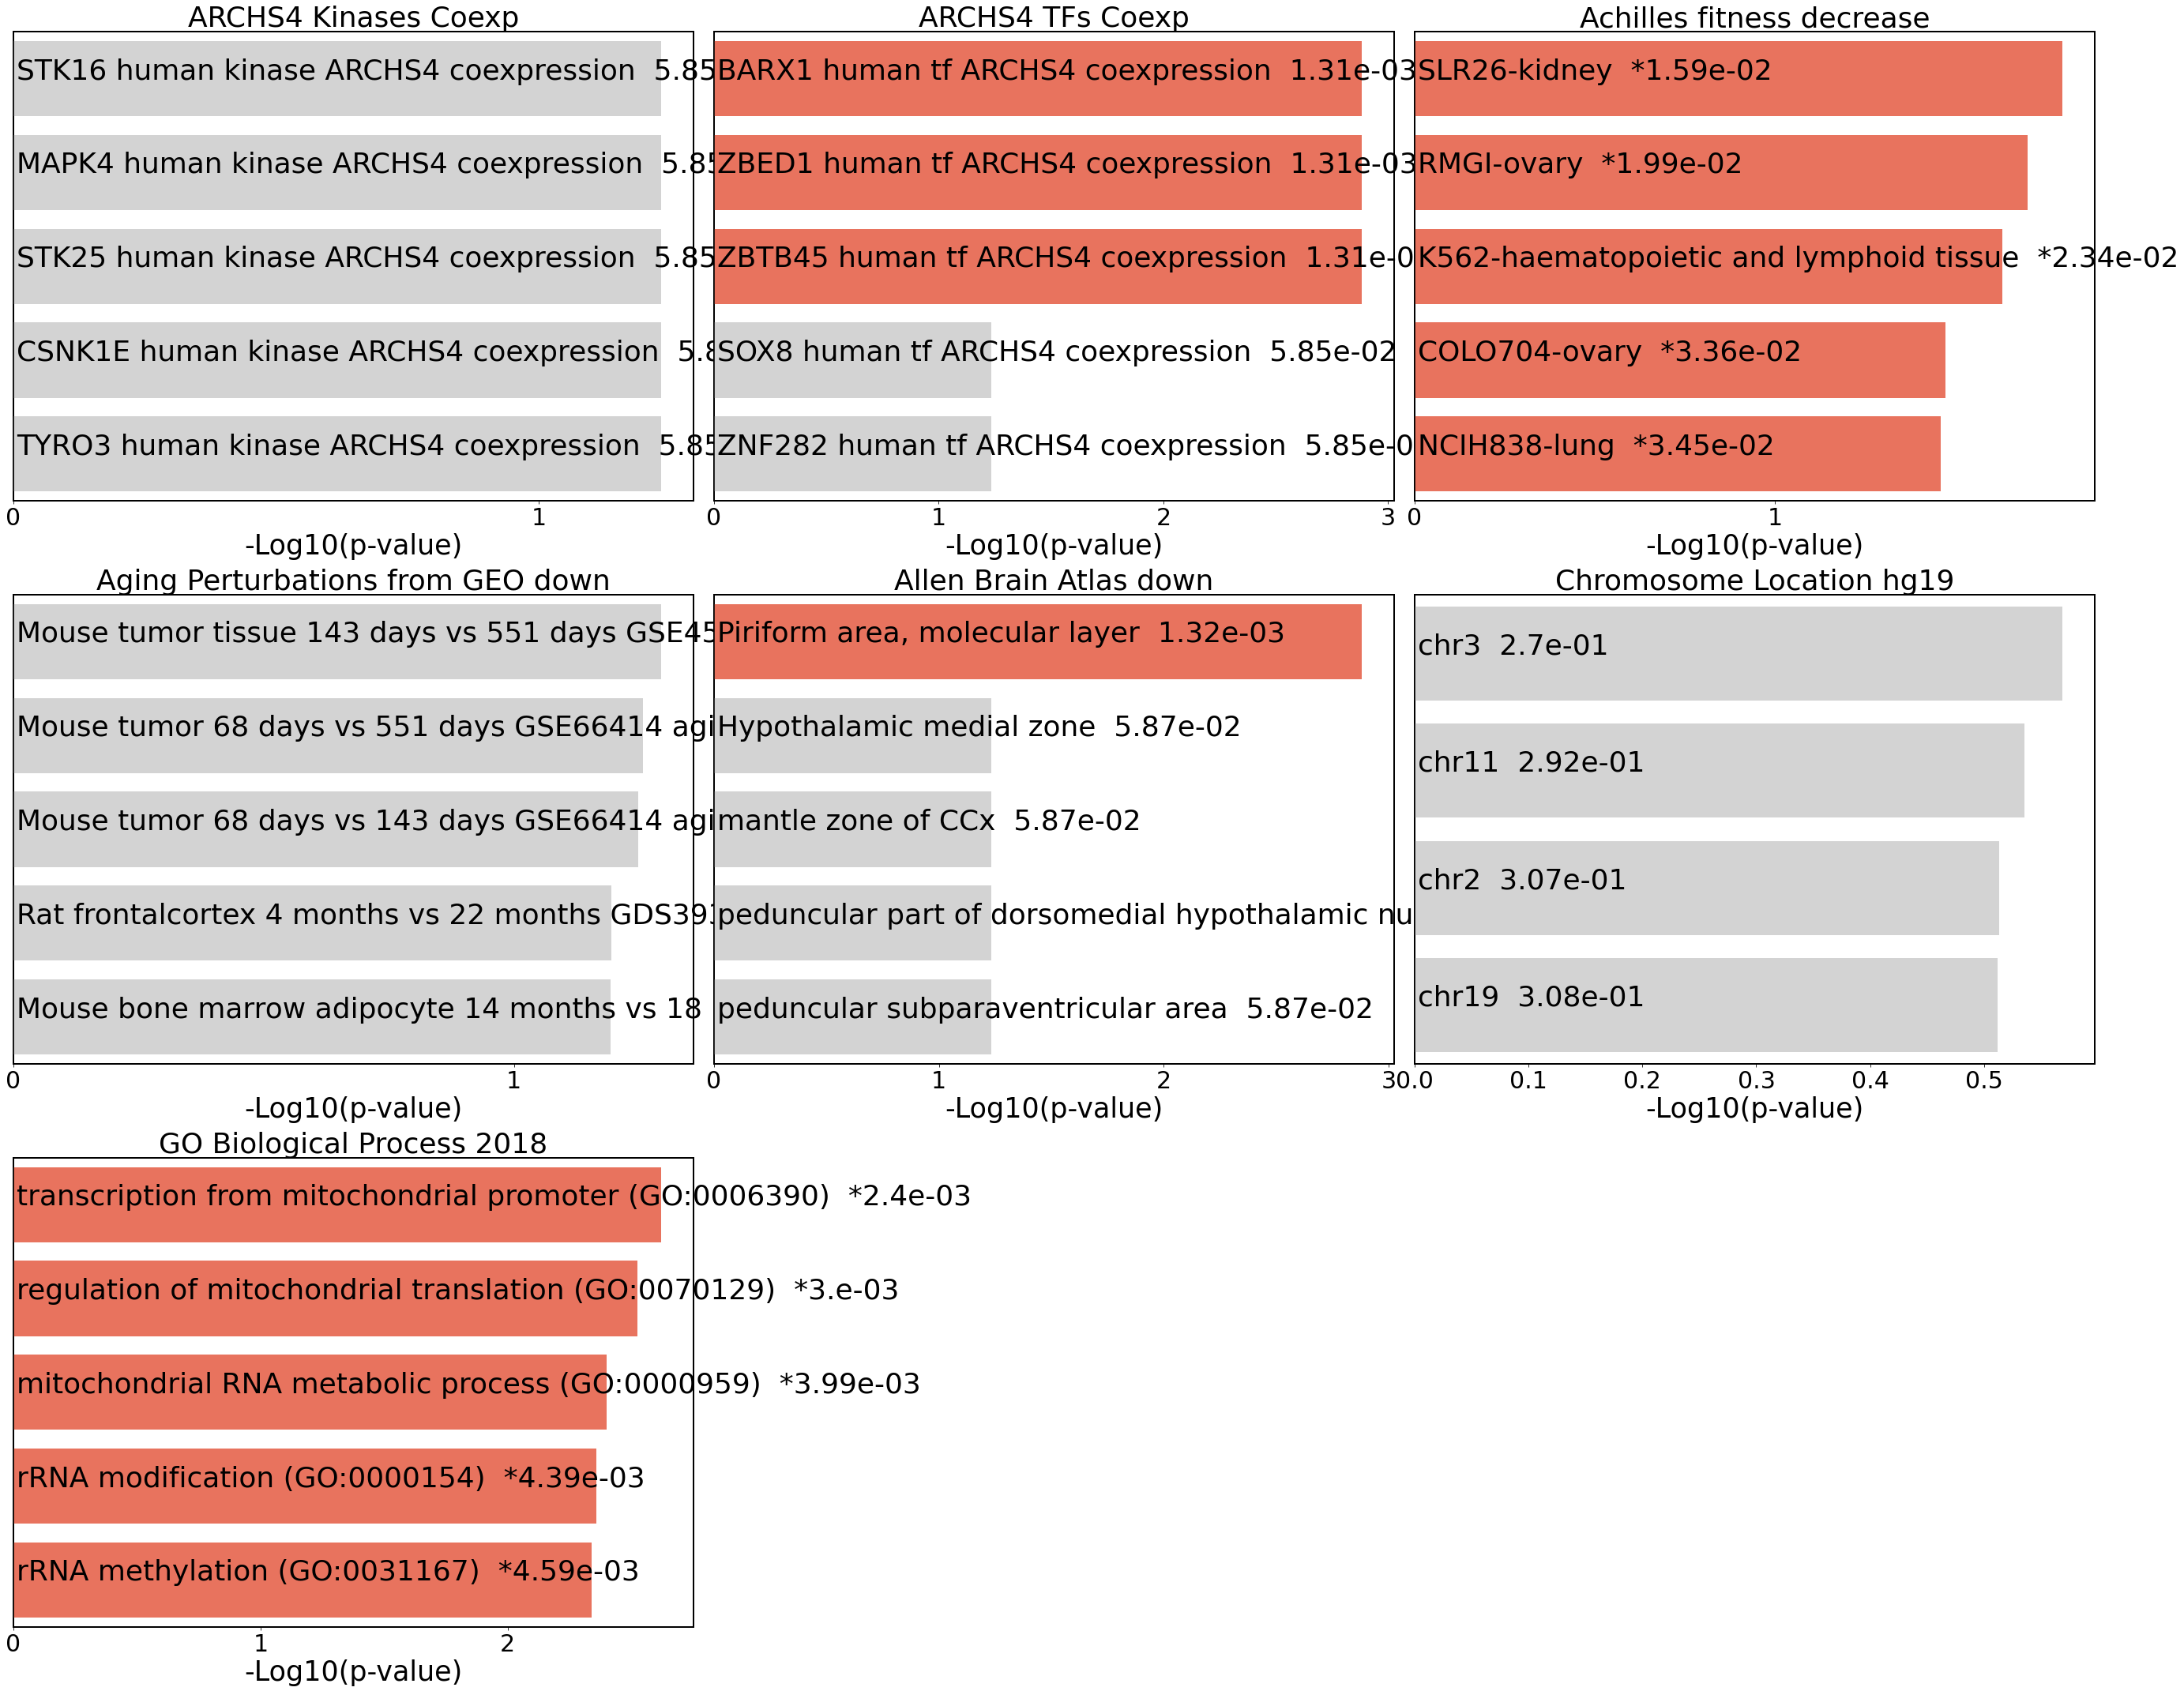

In [9]:
enrichr_figure(results[0],results[1],results[2],final_output_file_names, results[4],figure_file_format, color)

In [10]:
# Download bar graphs 
for i, file in enumerate(final_output_file_names):
    display(FileLink(file, result_html_prefix=str('Download ' + figure_file_format[i] + ': ')))

/tmp/appyter-tmpwpf7hvmk/Enrichr_results.png

In [11]:
# Get complete enrichment analysis results from Enrichr 
display(Markdown('Access your complete Enrichment results here: ' + str('https://amp.pharm.mssm.edu/Enrichr/enrich?dataset='+ results[3])))

Access your complete Enrichment results here: https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=409a255a324045a990040a2ad9b411c9